In [1]:
# All imports in one place for convenience
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups_vectorized
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
%matplotlib inline


## *20 newsgroups* dataset
For this example, you will use the *20 newsgroups* dataset, which can be loaded using scikit-learn's dataset library. The *20 newsgroups* dataset comprises around 18,000 newsgroups' posts on 20 topics.

In [2]:
dataset = fetch_20newsgroups_vectorized()
X, y = dataset.data, dataset.target

Use the following code to count the number of instances for each class.

In [3]:
for class_name, class_count  in zip(dataset.target_names, np.bincount(dataset.target)):
    print(class_name, class_count)

alt.atheism 480
comp.graphics 584
comp.os.ms-windows.misc 591
comp.sys.ibm.pc.hardware 590
comp.sys.mac.hardware 578
comp.windows.x 593
misc.forsale 585
rec.autos 594
rec.motorcycles 598
rec.sport.baseball 597
rec.sport.hockey 600
sci.crypt 595
sci.electronics 591
sci.med 594
sci.space 593
soc.religion.christian 599
talk.politics.guns 546
talk.politics.mideast 564
talk.politics.misc 465
talk.religion.misc 377


You can see that this is a *well-balanced dataset*. That is, each class is fairly evenly represented. Unfortunately, you won't always find such evenly distributed data in real life. So to look at the impact of an *unbalanced dataset*, reduce this dataset to just two classes: `sci.space` and everything else. First, make a copy of the target data. Then replace all instances of classes that are not `sci.space` with `0`, and replace all instances of `sci.space` with `1`.

To see the effect of this change, look at the counts for each class again:

In [4]:
y_2 = y.copy()
y_2[y_2 != 14] = 0
y_2[y_2 == 14] = 1

np.bincount(y_2)

array([10721,   593])

Now you have a dataset that is *class imbalanced*. That is, in the negative class, which represents posts that aren't about space, you have 10,721 instances. And in the positive class, representing posts about space, you only have 593 instances. Now you can train a classifier to predict if a post is about space or not. Use the logistic regression classifier, as shown below.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=82)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9671261930010604

Not bad! Without any tuning, you got an accuracy of `0.967`. An accuracy of 96.7% is quite good—but before you celebrate your data science skills, examine what this means in the context of an imbalanced dataset.

Suppose that you wrote a classifier that did no work at all, did not even look at the features, and just returned all predictions to be the dominant class. In this case, the dominant class is the negative class. So your dummy classifier would predict the negative class 100% of the time. What is the accuracy of the dummy classifier? Take a moment to think about it.

Recall the following:

$$ accuracy = \frac{ \# correct predictions}{all predictions}$$

Because you have 10,721 negative samples, your dummy classifier will be right 10,721 times and wrong 593 times.

$$ accuracy = \frac{10721}{10721 + 593} = 0.94759$$

Still pretty impressive!

Scikit-learn actually has a dummy classifier to help illustrate this exact scenario.

In [6]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)


0.9568752209261223

Remember, the dummy classifier does not actually use the features to make a prediction. It just looks at which class is dominant and returns that one every time. Here, on your test data, you get an accuracy of over 95%—almost as good as your real classifier. Given the closeness of these two results, can you really be confident that your classifier is doing all that great of a job?

This dummy classifier is quite useful for many reasons. It gives a null accuracy baseline to which you can compare your model's performance. This way, you know if your classifier is doing better than just a random guess.

If your model's accuracy is close to the null accuracy baseline, it might mean one of the following:

 - Your features are not good predictors for your problem.
 - Your algorithm's parameters may need tuning.
 - You have a large class imbalance.



## Confusion matrix
The *confusion matrix* is a table showing every combination of predicted and actual values. It makes it easy to see what type of errors your model is making, and it allows you to generate several metrics describing the performance of your model. Scikit-learn comes with a function to calculate the confusion matrix, given the set of actual values and the set of predictions.

### Why use a confusion matrix?

Although it is important to have good accuracy, accuracy does not tell the whole story.  The confusion matrix gives you a deeper understanding of what is going on with your classification model's performance by showing you how things are bucketed. It reveals which data points are bucketed correctly and which ones are not.

You will learn more about this in a bit.


In [7]:
predictions = lr.predict(X_test)

confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[  29   93]
 [   0 2707]]


You'll interpret this in a minute.

Although this gives you all the information that you need, it is not easy to read. To get a prettier picture of the confusion matrix, you could use [this function from Kaggle's website](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix), or any one of many similar functions that you may find on the web.

In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

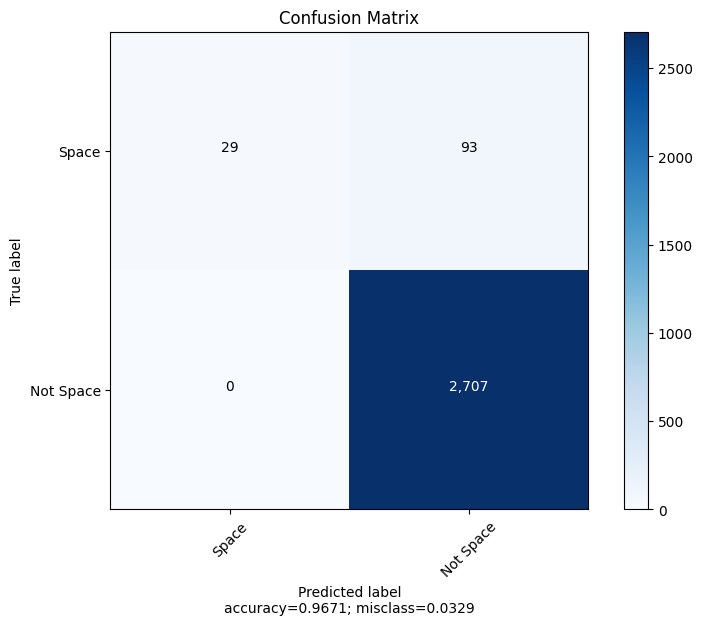

In [9]:
plot_confusion_matrix(cm=confusion, target_names = ['Space', 'Not Space'], title = 'Confusion Matrix',normalize=False)


Notice that the numbers that appear in the boxes of the plot above are the same as in the text-based matrix that scikit-learn produced. But this labeled diagram is much better to look at for visually evaluating a confusion matrix.

### Interpreting the matrix

But what do the numbers mean? Suppose that you trained a binary classification model to distinguish images of cats from images with no cats. You build a dataset of images and label which ones have cats and which ones do not. Then you run the model on a labeled test set with several images—some with cats and some without. Some of the images that have cats are correctly predicted, but some of the pictures of cats are falsely bucketed as not having cats. The reverse can also happen with pictures that are classified as not having cats—although some may be correctly predicted, some photos that do have cats may be misclassified as images without cats.

You could then count the number of times that your model correctly predicted cats, correctly predicted no cats, incorrectly predicted cats, and incorrectly predicted no cats. These are the numbers that you'd plug into the confusion matrix.

From the confusion matrix plotted above, you can define *true positives* (TP) as the number of times that the model correctly predicts the positive class (`cat`), and *true negatives* (TN) as the number of times that the model correctly predicts the negative class (`no cat`).

*False positives* (FP) is the number of times that the model incorrectly predicts the positive class, and *false negatives* (FN) is the number of times that the model incorrectly predicts the negative class. In statistics, false positives are called *Type I errors*, and false negatives are called *Type II errors*.

The true positives and true negatives are the total number of correct predictions, while the false positives and false negatives are the total number of wrong predictions.

There are several important metrics that can be calculated from the confusion matrix.

#### Accuracy

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{29 + 2707}{29 + 2707 + 0 + 93} = 0.967$$

Your model was 96.7% accurate. In other words, your model correctly classified 96.7% of the images.

#### Precision
*Precision* is a value that tells you what proportion of positive predictions are correct. That is, if the model has a precision of `0.75`, then 75% of its positive predictions are correct. Now, calculate the precision of your model.

$$precision = \frac{TP}{TP + FP} = \frac{29}{29 + 0} = 1.0$$

When your model predicts that a post is in the group `sci.space`, it is right 100% of the time!

Without looking at the precision score, you would have missed this by simply accepting the accuracy score at face value.

#### Recall
*Recall* is a value that tells you what proportion of instances in the positive class were correctly predicted. This is a good indication of how many positive instances are being missed.

$$recall = \frac{TP}{TP + FN} = \frac{29}{29 + 93} = 0.24$$

You found only 24% of all posts about space. (And you've missed the 76% of posts that were actually positive but came back as false negatives!)

#### Tradeoffs

There is often a tradeoff to be made between precision and recall. You may be able to tune your model to improve the precision (make fewer false positive predictions), but it comes at the cost of lower recall. Similarly, if you tune the model to improve the recall, then precision may suffer.

There is no one right way to tune your model. You have to decide on a case-by-case basis. Given the *20 newsgroups* dataset and the model that you trained, are you happy with your precision and recall scores? Well, that depends on how you plan to use this model and the business use case.

Suppose that you want to use this model as part of a system that automatically determines a label for new posts, so that you can recommend posts to people who are interested in space. Given a precision of 100%, all of the recommendations will be correct. But with a recall of only 24%, more than 75% of the posts about space will be incorrectly identified. Your users may be annoyed because you missed too many relevant posts (false negatives). For this scenario, if you improve the recall and catch more space posts but mislabel some recommendations, your users might be happier.

Now consider a screening test for a particular disease in the population. Suppose that you train a model to detect the disease given some symptoms of the patient. If the model predicts positive, you immediately send the patient for further tests and treatment. If the model predicts negative, then you assume the patient is safe. A low precision, in this case, means that many of the positive cases predicted would turn out to not have the disease. The high recall will mean that most of the positive cases are found. This seems about right. Imagine if the recall were low—many people with the disease would be incorrectly classified as not having the disease.

This is a case where recall is more important than precision, because it's important to avoid false negatives—you don't want to let people who need treatment to slip through the cracks (false negatives).


### F-score
When evaluating classifiers, it is convenient to combine the precision and recall into a single value called the *F-score* (also called the *$F_1$ score*). Use the F-score to see how the two metrics level out when combined.

This is done with the following formula:

$$F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{2 \times TP}{2 \times TP + FN + FP}$$

In computing this value, the contribution of precision and recall are equal.

There is a more general case of the $F_1$ score called the *$F_\beta$ score* (pronounced *F-beta score*). To calculate this score, a parameter $\beta$ is used to adjust the contribution of recall and precision. To favor precision, a value of $\beta < 1$ is used, and to favor recall, a value of $\beta > 1$ is used. This way, if you are building a model where precision is more important than recall, then set a value for $\beta$ less than 1. The formula is as follows:

$$F_\beta = (1 + \beta^2) \times \frac{\text{precision} \times \text{recall}}{(\beta^2 \times \text{precision}) + \text{recall}} = \frac{(1 + \beta^2) \times TP}{(1 + \beta^2) \times TP + \beta \times FN + FP}$$

You do not have to perform these calculations by hand. Scikit-learn provides functions in its metrics library for calculating these values. Each of these functions takes the actual target values and the predictions made by the model as inputs.

In [10]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
fbeta_precision = fbeta_score(y_test, predictions, beta=0.5)
fbeta_recall = fbeta_score(y_test, predictions, beta=2)

print('Accuracy score: {:.2f}'.format(accuracy))
print('Precision score: {:.2f}'.format(precision))
print('Recall score: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Accuracy score: 0.97
Precision score: 1.00
Recall score: 0.24
F1 score: 0.38
Fbeta score favoring precision: 0.61
FBeta score favoring recall: 0.28


Notice that the $F_\beta$ score with the $\beta < 1$ scored higher than the $F_\beta$ with $\beta > 1$. This is because you have a higher precision score than recall score.

The `classification_report` function is also useful for giving a summary of these metrics with a single call.

In [11]:
report = classification_report(y_test, predictions, target_names=['Not Space', 'Space'])
print(report)

              precision    recall  f1-score   support

   Not Space       0.97      1.00      0.98      2707
       Space       1.00      0.24      0.38       122

    accuracy                           0.97      2829
   macro avg       0.98      0.62      0.68      2829
weighted avg       0.97      0.97      0.96      2829



You could compare this report to the report on the dummy classifier. The dummy classifier can be used to make predictions in a similar way to a real classifier, except you will get all results being the dominant class. You know in this example that the dominant class is the negative class, so your dummy classifier won't predict any instances as the positive class.

In [12]:
dummy_report = classification_report(y_test, dummy.predict(X_test), target_names=['Not Space', 'Space'])
print(dummy_report)

              precision    recall  f1-score   support

   Not Space       0.96      1.00      0.98      2707
       Space       0.00      0.00      0.00       122

    accuracy                           0.96      2829
   macro avg       0.48      0.50      0.49      2829
weighted avg       0.92      0.96      0.94      2829



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The `UndefinedMetricWarning` is due to the fact that $TP + FP == 0$. This is a good indication that the classifier is not performing well, even though the accuracy is high. Even if your classifier did have a few FPs, the precision and recall would be quite low for that class.

## Decision function: Varying the probability threshold
Given some input, the model generates some probabilities for each input. This is given by the `predict_proba()` method. Rather than giving actual predictions, this method gives a probability that this instance belongs to the positive class.

The following code generates the list of probabilities for the test data and prints the first 30 values.

In [23]:
probs = lr.predict_proba(X_test)[:, 1]
print(probs[1:30])

[0.03045873 0.01633326 0.04686767 0.0330425  0.01673376 0.03064549
 0.03555476 0.03864876 0.03771071 0.03000802 0.0433192  0.03206011
 0.01691639 0.04610477 0.045327   0.0176444  0.03604467 0.02145434
 0.05960115 0.22718345 0.04970892 0.04448515 0.01503259 0.0268403
 0.02251283 0.02651896 0.05111075 0.03264745 0.03637281]


You have seen in the previous lesson that the probability threshold is `0.5`. That is, if the probability is greater than `0.5`, then you will predict positive. And if it is less than `0.5`, you will predict negative. In the plot below, the probabilities of all test samples are plotted in two distribution plots. The red plot is the negative class, and the green plot is the positive class. The blue line is the probability threshold.

Notice that there are positive instances on both sides of the threshold. That means that all positive instances on the left of the threshold will be incorrectly classified as negative—thereby giving false negatives.

<ipython-input-14-a4923a3da9e5>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pos, hist = False, kde = True, color='g',
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-14-a4923a3da9e5>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `k

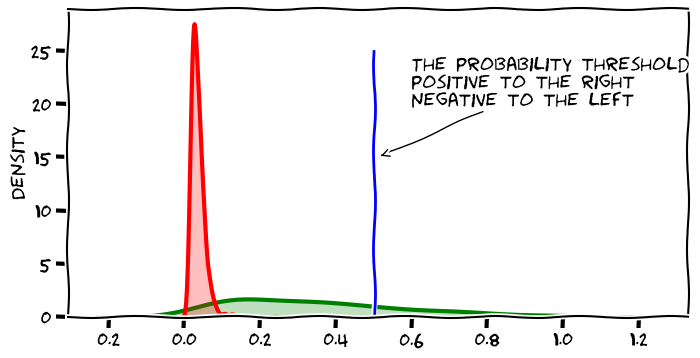

In [14]:
pos = [i for i, j in zip(probs, y_test) if j == 1]
neg = [i for i, j in zip(probs, y_test) if j == 0]

with plt.xkcd():
  fig = plt.figure(figsize=(8, 4))

  sns.distplot(pos, hist = False, kde = True, color='g',
                 kde_kws = {'shade': True, 'linewidth': 3})

  sns.distplot(neg, hist = False, kde = True, color='r',
                 kde_kws = {'shade': True, 'linewidth': 3})

  plt.plot([0.5, 0.5], [0, 25], '-b')
  plt.annotate(
        'The probability threshold\npositive to the right\nnegative to the left',
        xy=(0.51, 15), arrowprops=dict(arrowstyle='->'), xytext=(0.6, 20))

plt.show()

By adjusting the threshold, you can affect the recall and precision values. Suppose that you want to make sure that you get no false positives; that is, you do not want to classify any post as space if it isn't about space. You could move the threshold to the right until there are no red instances on the right side of the line. Correspondingly, that will mean that fewer positive instances will be correctly identified. Or, to put it another way, more positive instances will end up on the left of the threshold and will be incorrectly classified as negative.

## ROC curve
If you set the threshold to `0` (moving the threshold all the way to the left), then the model predicts `1` for all samples. You will get a *true positive rate* (TPR) of `1`; that is, all positive instances will be correctly predicted. You will also get a *false positive rate* (FPR) of `1` because all negative samples will be incorrectly predicted as positive.

If you set the threshold to `1`, then the model predicts `0` for all samples. You get a TPR of `0` because none of the actual positive samples will be correctly predicted. And you get an FPR of `0` because none of the negative class will be predicted as positive.

As you vary the threshold between these two extremes, you get different TPR and FPR values. You can plot these values to see the relationship between the values as the threshold moves.

The set of points that you get when you vary the threshold from `0` to `1` can be connected to describe a curve through space, which is called the *receiver operating characteristic* (ROC) curve.

The `sklearn.metrics.roc_curve` function calculates the FPR, TPR, and threshold values that you can use to plot a ROC curve. Below, the first 30 values are printed.

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
print(fpr[1:30])
print(tpr[1:30])
print(thresholds[1:30])

[0.         0.         0.00036941 0.00036941 0.00073883 0.00073883
 0.00110824 0.00110824 0.00147765 0.00147765 0.00184706 0.00184706
 0.00221648 0.00221648 0.00258589 0.00258589 0.00332471 0.00332471
 0.00369413 0.00369413 0.00480236 0.00480236 0.0059106  0.0059106
 0.00628001 0.00628001 0.00664943 0.00664943 0.00775767]
[0.00819672 0.46721311 0.46721311 0.48360656 0.48360656 0.5
 0.5        0.59016393 0.59016393 0.6147541  0.6147541  0.62295082
 0.62295082 0.64754098 0.64754098 0.68852459 0.68852459 0.70491803
 0.70491803 0.74590164 0.74590164 0.7704918  0.7704918  0.77868852
 0.77868852 0.78688525 0.78688525 0.80327869 0.80327869]
[0.98462604 0.3446592  0.34283523 0.3311512  0.32653259 0.32153467
 0.31893541 0.27469392 0.27468563 0.24375424 0.24159574 0.23921165
 0.23860809 0.21948719 0.20223596 0.18165188 0.17696934 0.16373987
 0.16369255 0.15575538 0.15284347 0.1478981  0.13727432 0.13693788
 0.13573329 0.13529207 0.13304517 0.13221123 0.12896697]


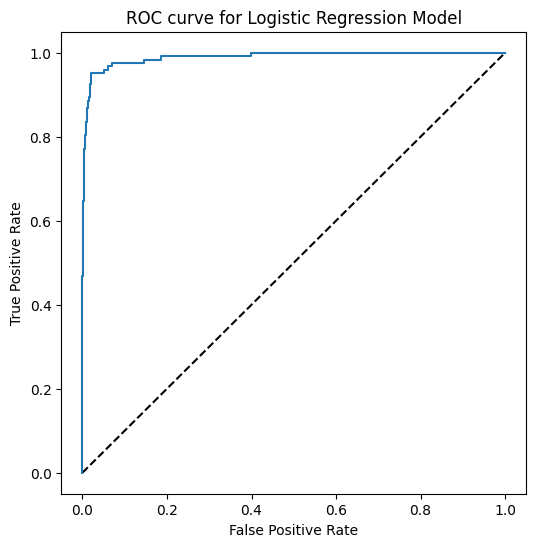

In [16]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

The top-left corner of this graph is the ideal spot: it minimizes the false positive rate and maximizes the true positive rate. So a steep curve that gets close to that corner is better than a shallow curve that remains close to the dashed baseline. That dashed line represents a 50% chance classifier. That is, any classifier that works as well as a coin toss will have a curve close to that line. But that is as good as random. So curves just above that line are better than random. The particular curve for this classifier is quite good; as you can see, it steeply climbs before leveling out.



## Precision-recall curve
Another useful visualization is the *precision-recall curve*. Similar to the ROC curve, it shows the relationship of precision to recall as the threshold is varied from `0` to `1`. Again, scikit-learn's metrics library provides a function that can help.

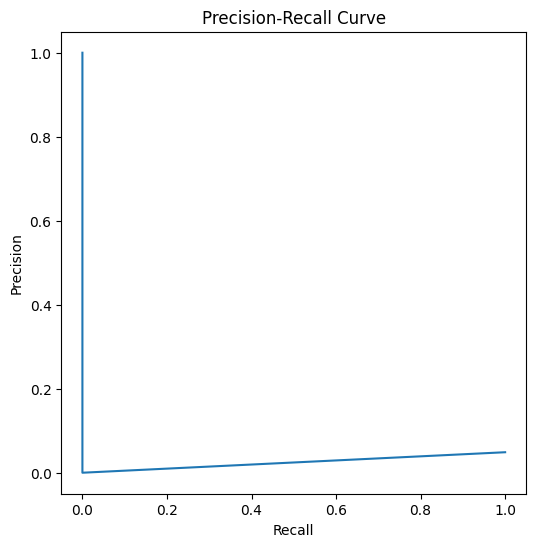

In [24]:
pres, rec, thresholds = precision_recall_curve(y_test, predictions)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In this case, you see a smooth drop in precision as recall increases. You won't always have such a smooth curve, but the general downward trend is expected.

Remember that these two visualizations serve slightly different purposes:

 - **ROC curves** are used when the classes are more or less balanced.
 - **Precision-recall curves** are used when there is a class imbalance.



## Area under the ROC curve
You can compute a useful metric from the ROC curve. Since the top-left corner is ideal, you want to favor curves that get as close to that corner as possible. If you measure the *area under the curve* (AUC), that metric will tell you how close you get to the ideal. In the plot below, the area under the curve and above the baseline is shaded. Notice that if the curve gets closer to the baseline, the area will be smaller.



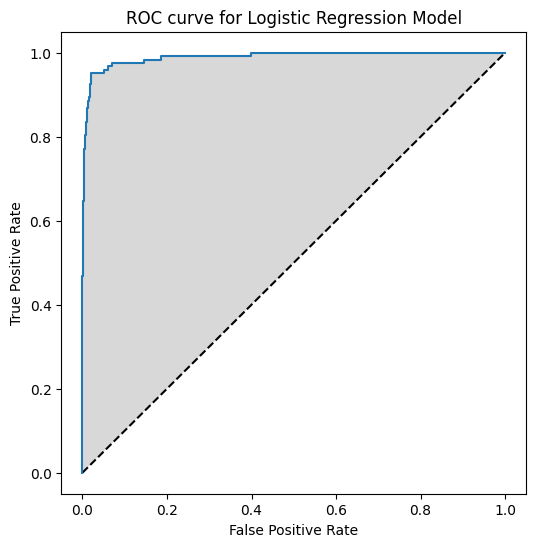

In [18]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

To calculate the area under the curve, use the `roc_auc_score` function from scikit-learn's metrics library. This function takes the actual labels and the predicted probabilities as input.

In [19]:
auc = roc_auc_score(y_test, probs)
print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.990


## Cross-validation
So far, you have been using a train-test split to reserve a portion of your data for testing. You do this so that you have some previously unseen data to test the model. If you train and test with the same data, you run the risk of overfitting the model to the training data.

But there is still a risk of overfitting to the test data itself. If you tune your model to perform well on the test data, what guarantee do you have that it will continue to perform as well on new data? Also, you know that the training algorithm is susceptible to small changes in the data. Recall from the discussion on linear classifiers that you are searching for a set of parameter values that optimizes a cost function. There is no absolute right answer to such a search. The values that you find are dependent on the data that you use to train the model.

By splitting the data into just training and testing, you drastically reduce the number of samples that can be used for learning the model, and the results can depend on a particular random choice for the pair of sets.

To see that illustrated, call `train_test_split` multiple times and train a model with the results each time. The `train_test_split` function randomly assigns data to the training set and test set. That means that each time you call the function, a different set of data is assigned to the test set.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('First split score: {:.3f}'.format(lr.score(X_test, y_test)))

X_train, X_test, y_train, y_test = train_test_split(X, y_2)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('Second split score: {:.3f}'.format(lr.score(X_test, y_test)))

First split score: 0.965
Second split score: 0.962


In the code above, `train_test_split` is called twice, and two models are trained with the results. Notice that the accuracy varies between the models. The implication is that you run the risk of randomly selecting a biased training or testing dataset, and you may end up with a model that does not generalize well to unseen data.

That is where *cross-validation* comes in.

Before you explore cross-validation, just a quick note about the randomness of `train_test_split`. If you get a different test set each time, and it results in a different accuracy score each time, how can you know whether any observed improvements are a result of your parameter tuning or just random chance? During model-building, it would be useful to create a test split that remains stable. To do this, use the `random_state` parameter (as you did at the beginning of this Notebook). This parameter takes an integer and uses it as the seed for the random generator. That means that you can specify the same number to get the same split each time. In the code below, two models are trained on two splits of the data again, this time with the same `random_state`.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=40)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('First split score: {:.3f}'.format(lr.score(X_test, y_test)))

X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=40)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('Second split score: {:.3f}'.format(lr.score(X_test, y_test)))

First split score: 0.964
Second split score: 0.964


Now back, to cross-validation. Cross-validation works by dividing the dataset into a specified number ($k$) of distinct sets called *folds*. Typically $k = 5$ or $k = 10$ folds, but you are free to use any number of folds that you wish. You then iterate the folds and train a model with $k - 1$ folds and use the remaining fold as the test set for validation. In each iteration, a different fold is used as the test set.

This yields $k$ accuracy scores for the $k$ models that are created and trained. But each model was trained on a different set of data and tested on a different set of data. Also, each data sample has a chance to be in the test set for one model. You can then find the mean of the scores to get an overall value for your model.

The `sklearn.model_selection.cross_val_score` function performs this cross-validation process, providing an array of scores for each model created. Remember that this may be an expensive process (in terms of time) because you have to create and train $k$ different models. Typically, you first split the data into the training and test set using `train_test_split`, as you did above. Then cross-validation is done on the training set, while the test set is held for the final evaluation of the selected model.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=40)
clf = LogisticRegression(solver='lbfgs')
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the five folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the five folds:  [0.95167943 0.96169711 0.95816146 0.95639364 0.95875074]
Mean cross-validation score: 0.957


Based on the scores, the model is able to predict consistently high on all five folds of the dataset. This provides assurance that the model is performing well on unseen data multiple times, and it was not just by the luck of the draw during the initial data split.


## Conclusion

The accuracy score does not tell the whole story, so you should use a variety of techniques in order to better understand how your classification model is performing.

Using the evaluation metrics discussed above, you can identify where your model is misclassifying. And you can use this information to improve the model in further iterations.  

To better focus your time and energy for the next model iterations, you also want to consider tradeoffs. How the model will be used will drive those decisions.

You can now use the various model evaluation techniques described above, along with cross-validation, to select the best-performing model for your next project.